<center><h1>Name: Shrey Shah</h1></center>
<center><h3>USC ID: 5061063668</h3></center>
<center><h3>Github: shreyshah97</h3></center>

### (a) Download Data

Package imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics

from scipy.io import arff
from sklearn.neighbors import KNeighborsClassifier
from tabulate import tabulate

Get the Vertebral Column Data Set

In [2]:
data = arff.loadarff('../data/vertebral_column_data/column_2C_weka.arff')
df = pd.DataFrame(data[0])
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,b'Abnormal'
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,b'Abnormal'
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,b'Abnormal'
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,b'Abnormal'
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,b'Abnormal'


Modify class labels

In [3]:
df['class'] = df['class'].replace([b'Abnormal'], 1)
df['class'] = df['class'].replace([b'Normal'], 0)
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1


### (b) Pre-Processing and Exploratory Data Analysis

#### i. Scatterplots

Text(0.5, 1.02, 'Scatter Plots of the independent variables in the data')

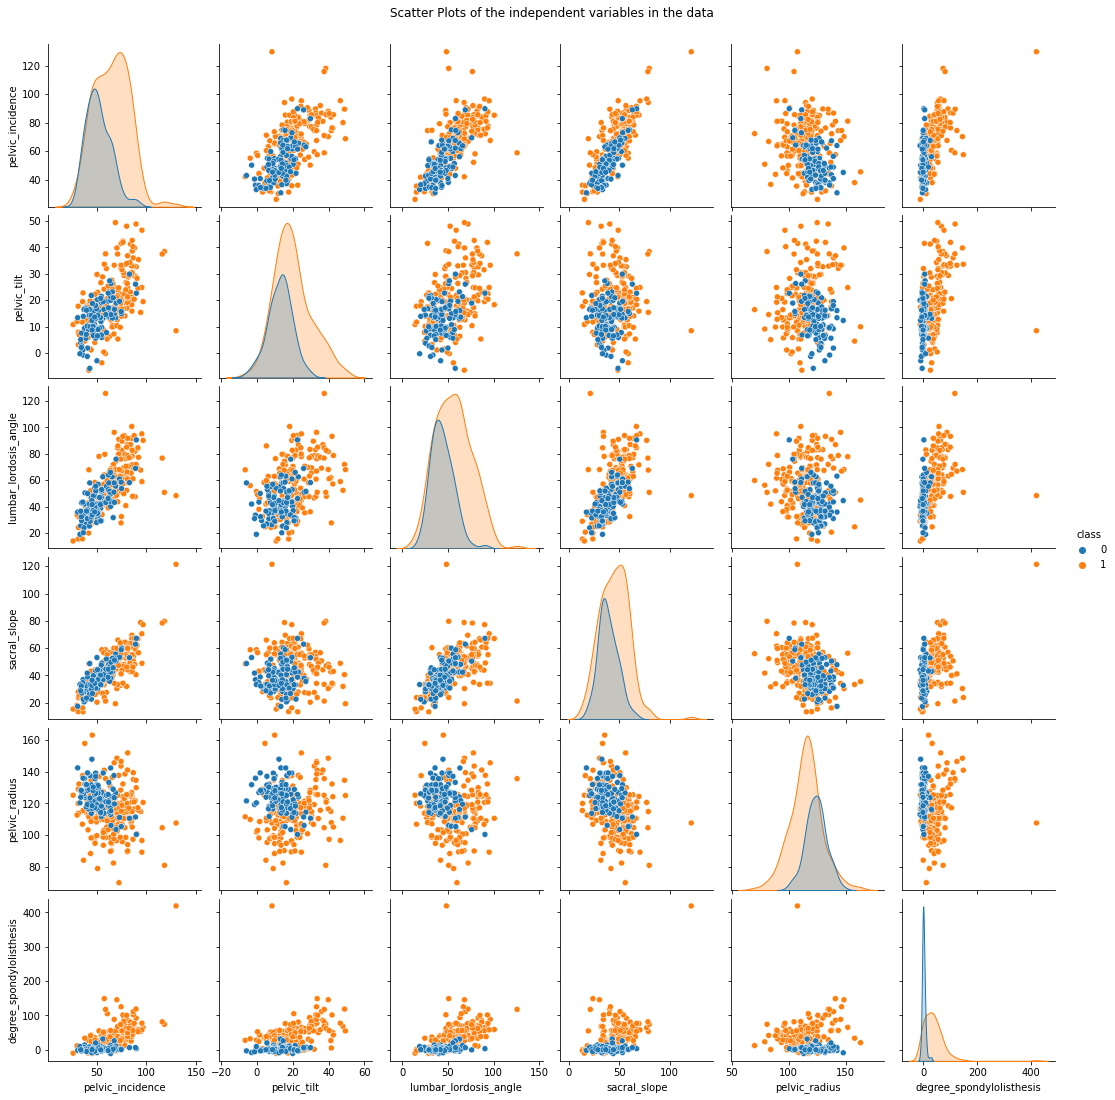

In [4]:
g = sns.pairplot(data=df, hue='class')
g.fig.suptitle("Scatter Plots of the independent variables in the data", y=1.02)

#### ii. Boxplots

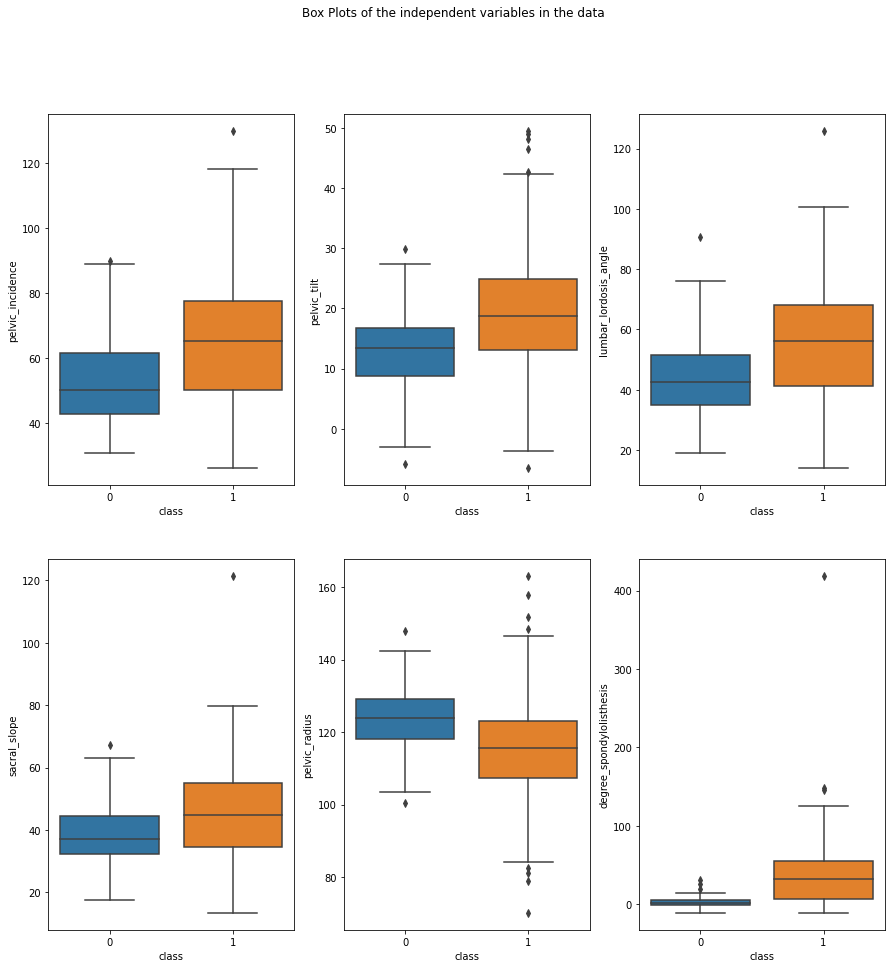

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(15,15))
fig.suptitle('Box Plots of the independent variables in the data')

for i in range(0,2):
    for j in range(0,3):
        sns.boxplot(x=df['class'], y=df.iloc[:,i*3+j], ax=ax[i,j], data=df)

#### iii. Split Data Set

In [6]:
# Take the rows as indicated in the homework as the training and testing data
train_0 = df.loc[df['class']==0][:70]
test_0 = df.loc[df['class']==0][70:]

train_1 = df.loc[df['class']==1][:140]
test_1 = df.loc[df['class']==1][140:]

# Concatenate the training and testing data for both the classes
train_df = pd.concat([train_0, train_1])
test_df = pd.concat([test_0, test_1])

# # Split the training and testing data into X and y
x_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1]
x_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

### (c) Classification

In [7]:
global MIN_TRAINING_ERROR, MIN_TRAINING_ERROR_WITHOUT_K1
MIN_TRAINING_ERROR = float('inf')
MIN_TRAINING_ERROR_WITHOUT_K1 = float('inf')
dic = {}

#### i. Euclidean Metric

In [8]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(x_train, y_train)
score = knn.score(x_test, y_test)
print("Accuracy of kNN with Euclidean metric: ", score)


Accuracy of kNN with Euclidean metric:  0.9


#### ii. Test Data

In [9]:
def KNN(k_array, x_train, y_train, x_test, y_test, metric='euclidean', p=2, weights='uniform'):
    
    global MIN_TRAINING_ERROR, MIN_TRAINING_ERROR_WITHOUT_K1
    best_error = [1]
    best_k = [-1]
    
    training_error_data = []
    testing_error_data = []
    matrix_inverse = np.linalg.inv(np.cov(x_train.T))
            
    for i in k_array:
        if metric == 'mahalanobis':
            knn = KNeighborsClassifier(n_neighbors = i, metric='mahalanobis', metric_params={'VI':matrix_inverse}, weights = weights)    
        else:
            knn = KNeighborsClassifier(n_neighbors = i, metric = metric, p = p, weights = weights)
        knn.fit(x_train, y_train)
        
        curr_score = knn.score(x_test, y_test)
        
        training_error = 1 - knn.score(x_train, y_train)
        testing_error  = 1 - knn.score(x_test, y_test)

        if training_error < MIN_TRAINING_ERROR_WITHOUT_K1 and i != 1:
            MIN_TRAINING_ERROR_WITHOUT_K1 = training_error
        
        if training_error < MIN_TRAINING_ERROR:
            MIN_TRAINING_ERROR = training_error
        
        training_error_data.append(training_error)
        testing_error_data.append(testing_error)
        
        if (1-curr_score) < best_error[0]:
            best_error = [1-curr_score]
            best_k = [i]
        elif (1-curr_score) == best_error[0]:
            best_error.append(1-curr_score)
            best_k.append(i)
        
    return best_error, best_k, training_error_data, testing_error_data

Plot Training and Testing errors vs K values

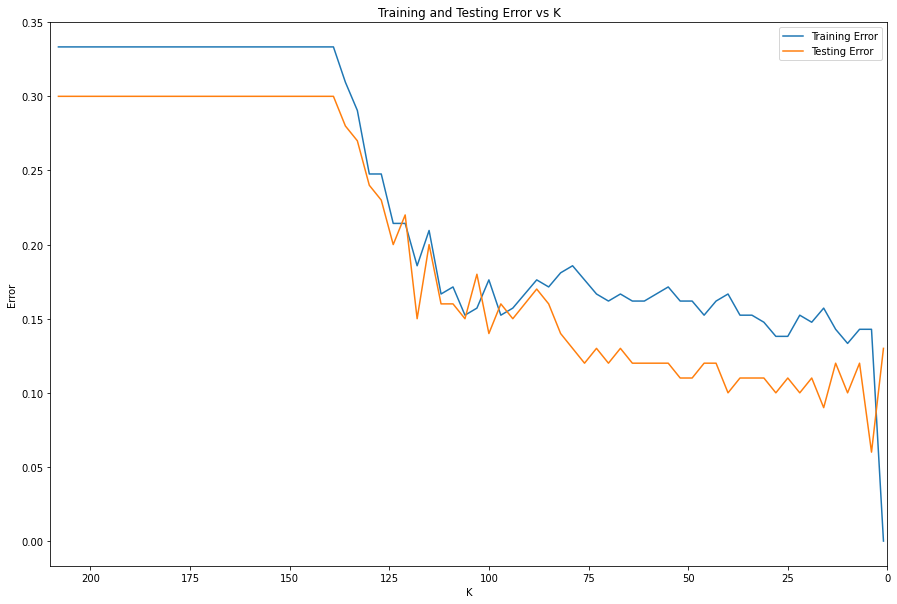

In [10]:
k_array = np.arange(1, 209, 3)
best_error, best_k, training_error_data, testing_error_data = KNN(k_array, x_train, y_train, x_test, y_test)
data = [[best_k[i], best_error[i]] for i in range(len(best_k))]
dic['Euclidean'] = data

plt.figure(figsize=(15,10))
plt.plot(k_array, training_error_data, label='Training Error')
plt.plot(k_array, testing_error_data, label='Testing Error')
plt.xlabel('K')
plt.ylabel('Error')
plt.title('Training and Testing Error vs K')
plt.legend()
plt.xlim(210,0)
plt.show()


Output the best K value and Calculate Metrics when K is the best K

In [11]:
knn = KNeighborsClassifier(n_neighbors=dic["Euclidean"][0][0], metric='euclidean')
knn.fit(x_train, y_train)
y_predict = knn.predict(x_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
precision_score = confusion_matrix[1][1]/(confusion_matrix[1][1] + confusion_matrix[0][1])
tnr = confusion_matrix[0][0]/(confusion_matrix[0][0] + confusion_matrix[0][1])
tpr = confusion_matrix[1][1]/(confusion_matrix[1][1] + confusion_matrix[1][0])
f1_score = 2*precision_score*tpr/(precision_score + tpr)

print(tabulate([data[0]+[confusion_matrix, tnr, tpr, precision_score, f1_score]],
      headers=['Best_K', 'Error', 'Confusion Matrix', 'True Negative Rate', 'True Positive Rate', 'Precision Score', 'F1 Score'], tablefmt='fancy_grid'))

╒══════════╤═════════╤════════════════════╤══════════════════════╤══════════════════════╤═══════════════════╤════════════╕
│   Best_K │   Error │ Confusion Matrix   │   True Negative Rate │   True Positive Rate │   Precision Score │   F1 Score │
╞══════════╪═════════╪════════════════════╪══════════════════════╪══════════════════════╪═══════════════════╪════════════╡
│        4 │    0.06 │ [[25  5]           │             0.833333 │             0.985714 │          0.932432 │   0.958333 │
│          │         │  [ 1 69]]          │                      │                      │                   │            │
╘══════════╧═════════╧════════════════════╧══════════════════════╧══════════════════════╧═══════════════════╧════════════╛


For future questions we will omit the k = 1 value (since it overfits the data) or show the calculations for k = 1 wherever possible like Learning Curve

#### iii. Learning Curve

In [12]:
def KNN_Euclidean_LC(n_array, df, x_test, y_test):
    best_error = []
    best_k = []
    best_error_without_1 = []
    best_k_without_1 = []
    for n in n_array:
        train_0 = df.loc[df['class']==0][:n//3]
        train_1 = df.loc[df['class']==1][:n-n//3]
        train_df = pd.concat([train_0, train_1])
        x_train = train_df.iloc[:,:-1]
        y_train = train_df.iloc[:,-1]

        # Learning Curve with k=1
        k_array = np.arange(1, n, 5)
        min_error, best_k_curr, _, _ = KNN(k_array, x_train, y_train, x_test, y_test)
        best_error_without_1.append(min_error[0])
        best_k_without_1.append(best_k_curr[0])

        # Learning Curve without k=1
        k_array = np.arange(6, n, 5)
        min_error, best_k_curr, _, _ = KNN(k_array, x_train, y_train, x_test, y_test)
        best_error.append(min_error[0])
        best_k.append(best_k_curr[0])
    return best_error, best_k, best_error_without_1, best_k_without_1

Plot the Learning Curves

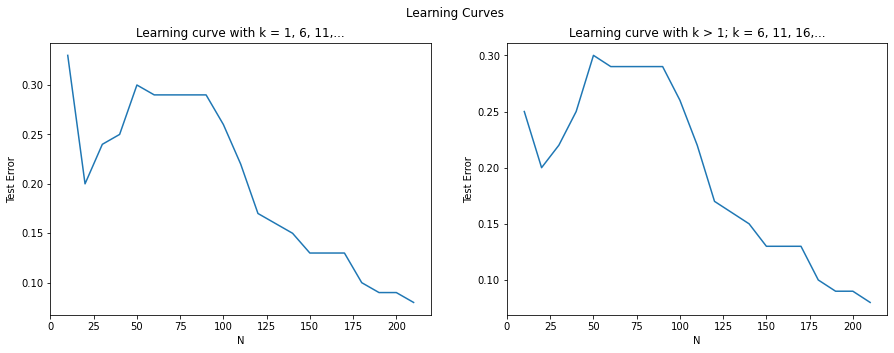

In [13]:
n_array = np.arange(10, 211, 10)
best_error, best_k, best_error_without_1, best_k_without_1 = KNN_Euclidean_LC(n_array, df, x_test, y_test)

# Plotting Learning Curve including k=1
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Learning Curves')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Test Error')
ax[0].plot(n_array, best_error)
ax[0].set_title('Learning curve with k = 1, 6, 11,...')

# Plotting Learning Curve without k=1
ax[1].set_xlabel('N')
ax[1].set_ylabel('Test Error')
ax[1].plot(n_array, best_error_without_1)
ax[1].set_title('Learning curve with k > 1; k = 6, 11, 16,...')
plt.show()

### (d) Other Metrics

#### i. Minkowski Distance.

##### A. Manhattan Distance with p = 1.

In [14]:
k_array = np.arange(1, 200, 5)
best_error, best_k, training_error_data, testing_error_data = KNN(k_array, x_train, y_train, x_test, y_test, metric='manhattan', p=1)
# data = [[best_k[i], best_error[i]] for i in range(len(best_k))]
data = [[best_k[1], best_error[1]]]
dic["Manhattan"] = data
print(tabulate(data, headers=['Best_K', 'Error'], tablefmt='fancy_grid'))

╒══════════╤═════════╕
│   Best_K │   Error │
╞══════════╪═════════╡
│        6 │    0.11 │
╘══════════╧═════════╛


Here k = 1 gives the least error, but we know that it overfits the data so for part(B) we will use k = 6

##### B. With log10(p) in {0.1, 0.2, 0.3, ... ,1}.

In [15]:
def KNN_Minkowski(k, p_array, x_train, y_train, x_test, y_test):
        
    best_score = -1
    best_p = 0
    
    for p in p_array:
        p2 = 10**p
        knn = KNeighborsClassifier(n_neighbors = k, metric = 'minkowski', p = p2)
        knn.fit(x_train, y_train)
        
        curr_score = knn.score(x_test, y_test)
        
        if curr_score > best_score:
            best_score = curr_score
            best_p = p

        min_error = 1 - best_score
        
    return min_error, best_p

In [16]:
p_array = np.arange(0.1, 1.1, 0.1)
data = []
min_error = 1
best_error, best_p = KNN_Minkowski(dic["Manhattan"][0][0], p_array, x_train, y_train, x_test, y_test)
best_p = round(best_p, 1)
if best_error < min_error:
    min_error = best_error
data.append([dic["Manhattan"][0][0], best_p, best_error])

dic["Minkowski"] = data
print(tabulate(data, headers=['Best_K', 'Best Log10P', 'Error'], tablefmt='fancy_grid'))

╒══════════╤═══════════════╤═════════╕
│   Best_K │   Best Log10P │   Error │
╞══════════╪═══════════════╪═════════╡
│        6 │           0.6 │    0.06 │
╘══════════╧═══════════════╧═════════╛


##### C. Chebyshev Distance With p -> infinity.

In [17]:
k_array = np.arange(1, 200, 5)
best_error, best_k, _, _ = KNN(k_array, x_train, y_train, x_test, y_test, metric='minkowski', p=float('inf'))
data = [[best_k[i], best_error[i]] for i in range(len(best_k))]
dic["Chebyshev"] = data
print(tabulate(data, headers=['Best_K', 'Error'], tablefmt='fancy_grid'))

╒══════════╤═════════╕
│   Best_K │   Error │
╞══════════╪═════════╡
│       16 │    0.08 │
╘══════════╧═════════╛


#### ii. Mahalanobis Distance.

In [18]:
k_array = np.arange(1, 200, 5)
best_error, best_k, training_error_data, testing_error_data = KNN(k_array, x_train, y_train, x_test, y_test, metric='mahalanobis')
# data = [[best_k[i], best_error[i]] for i in range(len(best_k))]
data = [[best_k[1], best_error[1]]]
dic["Mahalanobis"] = data
print(tabulate(data, headers=['Best_K', 'Error'], tablefmt='fancy_grid'))

╒══════════╤═════════╕
│   Best_K │   Error │
╞══════════╪═════════╡
│        6 │    0.16 │
╘══════════╧═════════╛


Summary (d)

In [19]:
data = []
for k,v in dic.items():
    for i,x in enumerate(v):
        if len(x)==2:
            if(i==0):
                data.append([k, x[0], x[1]])
            else:
                data.append(["", x[0], x[1]])
        else:
            data.append([k+"\nLog10P value "+str(x[1]), x[0], x[2]])
print(tabulate(data, headers=['Metric', 'K', 'Error Rate'], tablefmt='fancy_grid'))

╒══════════════════╤═════╤══════════════╕
│ Metric           │   K │   Error Rate │
╞══════════════════╪═════╪══════════════╡
│ Euclidean        │   4 │         0.06 │
├──────────────────┼─────┼──────────────┤
│ Manhattan        │   6 │         0.11 │
├──────────────────┼─────┼──────────────┤
│ Minkowski        │   6 │         0.06 │
│ Log10P value 0.6 │     │              │
├──────────────────┼─────┼──────────────┤
│ Chebyshev        │  16 │         0.08 │
├──────────────────┼─────┼──────────────┤
│ Mahalanobis      │   6 │         0.16 │
╘══════════════════╧═════╧══════════════╛


### (e) Weighted Decision

In [20]:
dic2 = {}
k_array = np.arange(1, 200, 5)
best_error, best_k, _, _ = KNN(k_array, x_train, y_train, x_test, y_test, metric='euclidean', weights='distance')
data = [[best_k[i], best_error[i]] for i in range(len(best_k))]
dic2["Euclidean"] = data
best_error, best_k, _, _ = KNN(k_array, x_train, y_train, x_test, y_test, metric='manhattan', weights='distance')
data = [[best_k[i], best_error[i]] for i in range(len(best_k))]
dic2["Manhattan"] = data
best_error, best_k, _, _ = KNN(k_array, x_train, y_train, x_test, y_test, metric='chebyshev', weights='distance')
data = [[best_k[i], best_error[i]] for i in range(len(best_k))]
dic2["Chebyshev"] = data

In [21]:
data = []
for k,v in dic2.items():
    for i,x in enumerate(v):
        if len(x)==2:
            if(i==0):
                data.append([k, x[0], x[1]])
            else:
                data.append(["", x[0], x[1]])
print(tabulate(data, headers=['Metric', 'Best_K', 'Error'], tablefmt='fancy_grid'))

╒═══════════╤══════════╤═════════╕
│ Metric    │   Best_K │   Error │
╞═══════════╪══════════╪═════════╡
│ Euclidean │        6 │    0.1  │
├───────────┼──────────┼─────────┤
│ Manhattan │       26 │    0.1  │
├───────────┼──────────┼─────────┤
│ Chebyshev │       16 │    0.11 │
├───────────┼──────────┼─────────┤
│           │       31 │    0.11 │
├───────────┼──────────┼─────────┤
│           │       36 │    0.11 │
├───────────┼──────────┼─────────┤
│           │       41 │    0.11 │
├───────────┼──────────┼─────────┤
│           │       61 │    0.11 │
╘═══════════╧══════════╧═════════╛


### (f) Training Error Rate

In [22]:
print("Minimum Training error including k = 1: ", MIN_TRAINING_ERROR)
print("Minimum Training error ignoring k = 1: ", MIN_TRAINING_ERROR_WITHOUT_K1)

Minimum Training error including k = 1:  0.0
Minimum Training error ignoring k = 1:  0.0


References

https://drive.google.com/file/d/1k-X98LFcyksy5QCsp7-GXH319-v7vMHw/view?usp=share_link<br>
https://stackoverflow.com/questions/27264426/arff-files-with-scikit-learn<br>
https://stackoverflow.com/questions/61599926/python-scatter-plot-for-all-independent-variables<br>
https://stackoverflow.com/questions/50294951/python-boxplot-on-single-variables><br>
https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8<br>
https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn<br>
https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/